In [1]:
import os

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from rdquantum.hamiltonian import Rydberg_Cz

In [2]:
# Define Hamiltonian
H = Rydberg_Cz()

In [3]:
# Create environment
env = gym.make('rdquantum/HamiltonianTrainer-v2023.04.22', Hamiltonian=Rydberg_Cz)
observation, info = env.reset()
# print(observation, info)

In [4]:
# Hyperparameters
algo = 'PPO'
B = 30 # batch_size
EPOCHS = 50
eval_interval = 1
lr = 1e-2 # 1e-2 for SGD
policy_steps = 20

log_prob_clip = 5
grad_clip = 0.001
importance_ratio_eps = 0.2
value_loss_coeff = 0.5

optimizer = tf.optimizers.Adam(learning_rate=lr)
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

In [5]:
# rootdir = r'.'
r_amp = H.r_amp
r_gate_time = H.r_gate_time
# print(r_amp, r_gate_time)


# trainable variables
actions = ['omega_p_amp', 'omega_r_amp', 'delta_p_amp', 'gate_time']
mean = {s : tf.Variable(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), name='mean_'+s) for s in actions}
sigma = {s : tf.Variable(0.5, name='sigma_'+s) for s in actions}
baseline = tf.Variable(0.0, name='baseline')

In [6]:
print(mean)
print(sigma)
print(baseline)

{'omega_p_amp': <tf.Variable 'mean_omega_p_amp:0' shape=() dtype=float32, numpy=0.6280091>, 'omega_r_amp': <tf.Variable 'mean_omega_r_amp:0' shape=() dtype=float32, numpy=0.65865195>, 'delta_p_amp': <tf.Variable 'mean_delta_p_amp:0' shape=() dtype=float32, numpy=0.44461775>, 'gate_time': <tf.Variable 'mean_gate_time:0' shape=() dtype=float32, numpy=0.932768>}
{'omega_p_amp': <tf.Variable 'sigma_omega_p_amp:0' shape=() dtype=float32, numpy=0.5>, 'omega_r_amp': <tf.Variable 'sigma_omega_r_amp:0' shape=() dtype=float32, numpy=0.5>, 'delta_p_amp': <tf.Variable 'sigma_delta_p_amp:0' shape=() dtype=float32, numpy=0.5>, 'gate_time': <tf.Variable 'sigma_gate_time:0' shape=() dtype=float32, numpy=0.5>}
<tf.Variable 'baseline:0' shape=() dtype=float32, numpy=0.0>


In [7]:
test_action = {
    'omega_p_amp': [100/H.r_amp],
    'omega_r_amp': [175/H.r_amp],
    'delta_p_amp': [400/H.r_amp],
    'gate_time': [1.0/H.r_gate_time]
}

In [8]:
def reward_sampler(a):
    # print('a: ', a, '\n')
    rewards = []
    
    for i in range(B):
        a_np = {s : np.array(a[s][i]) for s in actions}
        # print('a_np: ', a_np, '\n')
        observation, reward, terminated, truncated, info = env.step(a_np)
        rewards.append(reward)

    return tf.cast(rewards, tf.float32)

In [9]:
def compute_log_prob(a, mean, sigma):
    sigma_eps = 1e-5 # for mumerical stability
    log_prob = 0.
    for s in actions:
        log_prob += - tf.math.log(tf.math.abs(sigma[s]) + sigma_eps) \
            - 0.5 * (a[s] - mean[s])**2 / (sigma[s]**2 + sigma_eps)
    return log_prob

In [10]:
def action_sampler(actions, sample_batch = 1):
    N = {s : tfp.distributions.TruncatedNormal(loc=mean[s], scale=sigma[s], low=0, high=1) for s in actions}
    a = {s : N[s].sample(sample_batch) for s in actions}
    return a

In [11]:
train_samples = 0
train_rewards = []
log = dict(train_rewards=[], train_epochs=[], eval_rewards=[], eval_epochs=[],
           train_actions=[], mean=[], sigma=[], baseline=[], train_samples=[],
          mean_omega_p_amp=[], mean_omega_r_amp=[], mean_delta_p_amp=[],
          mean_gate_time=[], sigma_omega_p_amp=[], sigma_omega_r_amp=[],
          sigma_delta_p_amp=[], sigma_gate_time=[], gate_time=[])

for epoch in range(1,EPOCHS+1):

    train_samples += B

    # sample a batch of actions from Gaussian policy
    a = action_sampler(actions, sample_batch=B)

    # collect those rewards
    R =  reward_sampler(a)

    # log prob according to old policy (required for importance ratio)
    for s in actions:
        log['mean_'+s].append(mean[s].numpy())
        log['sigma_'+s].append(sigma[s].numpy())
    log['baseline'].append(baseline.numpy())
    if epoch == 1: mean_old, sigma_old = mean, sigma
    log_prob_old = compute_log_prob(a, mean_old, sigma_old)
    log_prob_old = tf.clip_by_value(log_prob_old, -log_prob_clip, log_prob_clip)
    mean_old = tf.nest.map_structure(tf.identity, mean)
    sigma_old = tf.nest.map_structure(tf.identity, sigma)
    
    # calculate policy loss and do several gradient updates
    for i in range(policy_steps):
        with tf.GradientTape(persistent=True) as tape:
            # log prob according to the current policy
            log_prob = compute_log_prob(a, mean, sigma)
            log_prob = tf.clip_by_value(log_prob, -log_prob_clip, log_prob_clip)

            A = R - baseline # action advantages

            if algo == 'REINFORCE':
                policy_loss_batch = - A * log_prob

            if algo == 'PPO':
                importance_ratio = tf.math.exp(log_prob - log_prob_old)
                importance_ratio_clip = tf.clip_by_value(importance_ratio, 
                            1-importance_ratio_eps, 1+importance_ratio_eps)
                policy_loss_batch = -tf.minimum(importance_ratio*A, importance_ratio_clip*A)

            policy_loss = tf.reduce_mean(policy_loss_batch) # reduce over batch
            value_loss = tf.reduce_mean(A**2)
            loss = policy_loss + value_loss_coeff * value_loss
            # print(loss)

            grads = tape.gradient(loss, tape.watched_variables())
            grads = tf.clip_by_value(grads, -grad_clip, grad_clip)
            optimizer.apply_gradients(zip(grads, tape.watched_variables()))

    log['train_rewards'].append(np.array(R))
    log['train_actions'].append(np.array(a))
    log['train_epochs'].append(epoch)
    log['train_samples'].append(train_samples)
    if epoch % eval_interval == 0:
        a_evl = action_sampler(actions, sample_batch=1)
        a_evl = {s : np.array(a_evl[s][0]) for s in actions}
        # print(a_evl)
        fidelity = H.evaluation(a_evl)
        print('Epoch %d: Fidelity = %.4f' %(epoch, fidelity))
        print('mean_omega_p_amp: %4f' %(log['mean_omega_p_amp'][-1]))
        print('sigma_omega_p_amp: %4f' %(log['sigma_omega_p_amp'][-1]))
        print('baseline: %4f' %(log['baseline'][-1]))
        

run_params = dict(B = B, EPOCHS = EPOCHS, eval_interval = eval_interval,
        lr = lr, policy_steps = policy_steps, log_prob_clip = log_prob_clip,
        grad_clip = grad_clip, importance_ratio_eps = importance_ratio_eps,
        value_loss_coeff = value_loss_coeff)            

Epoch 1: Fidelity = 0.5616
mean_omega_p_amp: 0.628009
sigma_omega_p_amp: 0.500000
baseline: 0.000000
Epoch 2: Fidelity = 0.4336
mean_omega_p_amp: 0.510430
sigma_omega_p_amp: 0.426643
baseline: -0.199758
Epoch 3: Fidelity = 0.7478
mean_omega_p_amp: 0.601326
sigma_omega_p_amp: 0.455814
baseline: -0.399640
Epoch 4: Fidelity = 0.7793
mean_omega_p_amp: 0.501804
sigma_omega_p_amp: 0.441374
baseline: -0.599548
Epoch 5: Fidelity = 0.7509
mean_omega_p_amp: 0.565108
sigma_omega_p_amp: 0.480456
baseline: -0.799470
Epoch 6: Fidelity = 0.4190
mean_omega_p_amp: 0.499371
sigma_omega_p_amp: 0.349974
baseline: -0.999401
Epoch 7: Fidelity = 0.5623
mean_omega_p_amp: 0.551336
sigma_omega_p_amp: 0.282438
baseline: -0.986308
Epoch 8: Fidelity = 0.6637
mean_omega_p_amp: 0.509536
sigma_omega_p_amp: 0.307735
baseline: -1.001862
Epoch 9: Fidelity = 0.5279
mean_omega_p_amp: 0.554129
sigma_omega_p_amp: 0.275424
baseline: -0.983965
Epoch 10: Fidelity = 0.5107
mean_omega_p_amp: 0.519806
sigma_omega_p_amp: 0.223552


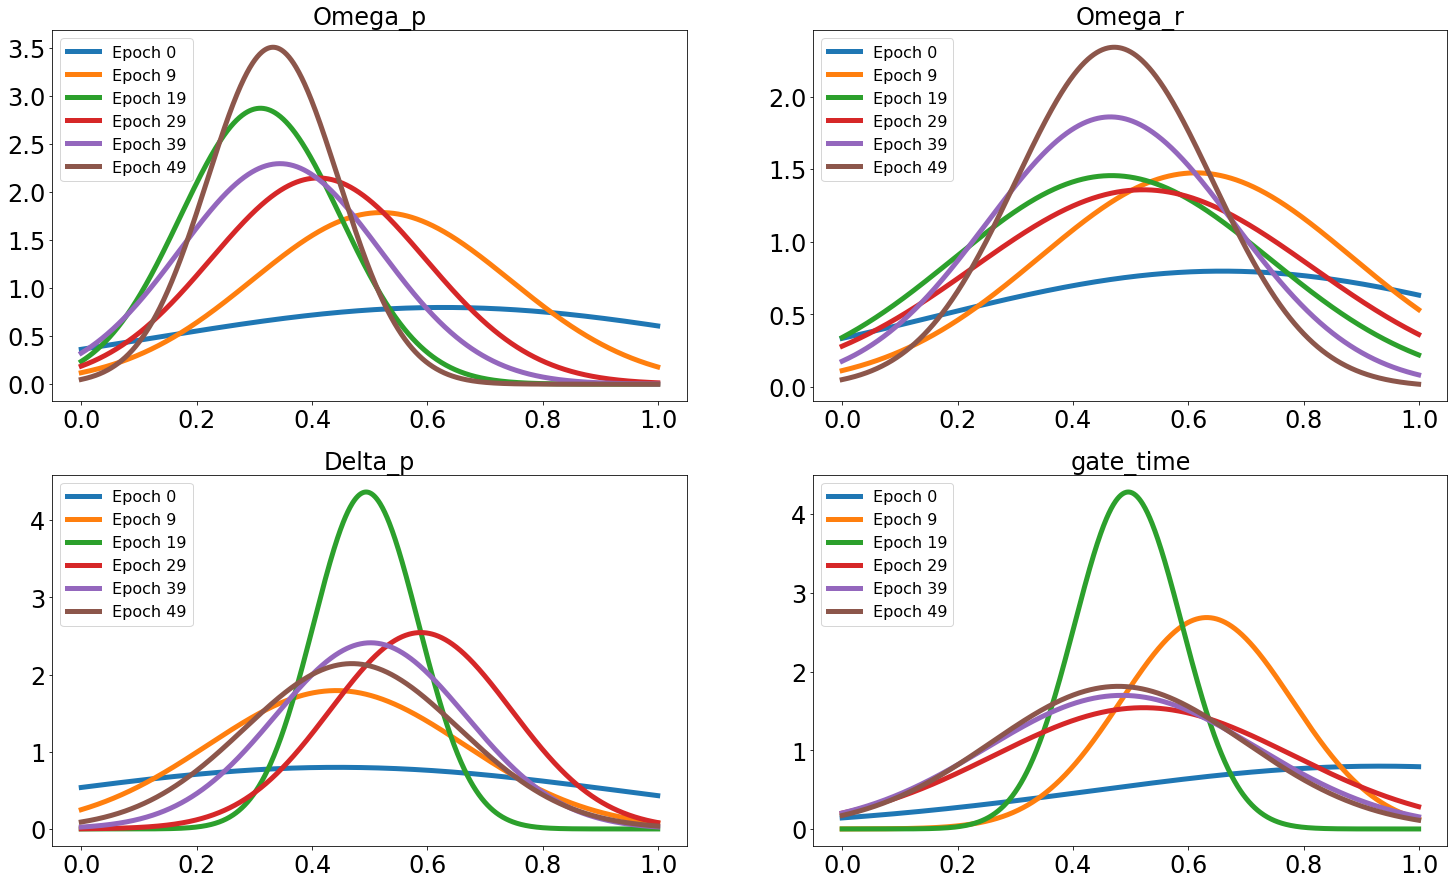

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x_axis = np.arange(0, 1, 0.001)

plt.figure(figsize=(25, 15))

plt.subplot(221)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_omega_p_amp'][i],log['sigma_omega_p_amp'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Omega_p', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(222)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_omega_r_amp'][i],log['sigma_omega_r_amp'][i]), linewidth=5, label="Epoch %d" %i)    
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Omega_r', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(223)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_delta_p_amp'][i],log['sigma_delta_p_amp'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Delta_p', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(224)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_gate_time'][i],log['sigma_gate_time'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('gate_time', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

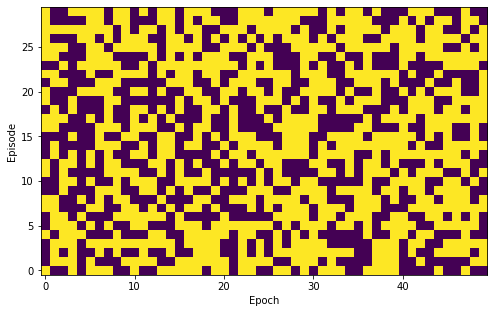

In [12]:
result = np.array(log['train_rewards'])
plt.matshow(np.reshape(result, (EPOCHS, B)).transpose())
plt.xlabel("Epoch")
plt.ylabel("Episode")
plt.gca().invert_yaxis()
plt.gca().tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
# plt.colorbar()

In [17]:
log['mean_omega_p_amp']

[0.6280091,
 0.51042956,
 0.60132587,
 0.5018036,
 0.5651077,
 0.4993714,
 0.551336,
 0.50953597,
 0.55412865,
 0.5198062,
 0.5665645,
 0.5335963,
 0.5214773,
 0.4481605,
 0.42987946,
 0.4436173,
 0.36971363,
 0.36130583,
 0.3655629,
 0.3105257,
 0.25558987,
 0.24967869,
 0.27252313,
 0.29171032,
 0.29985502,
 0.2777985,
 0.33555752,
 0.33725142,
 0.38946596,
 0.41054547,
 0.40415275,
 0.39621407,
 0.4301048,
 0.41126108,
 0.3767779,
 0.31940442,
 0.3230692,
 0.3620976,
 0.32413214,
 0.34432742,
 0.35804707,
 0.32030016,
 0.32812405,
 0.33956414,
 0.3183421,
 0.35360372,
 0.33349162,
 0.32439297,
 0.31591797,
 0.33233604]

In [14]:
log['mean_omega_r_amp']

[0.65865195,
 0.5573253,
 0.65203667,
 0.5970227,
 0.56463355,
 0.6438597,
 0.60153884,
 0.68651533,
 0.6122797,
 0.6129892,
 0.58595425,
 0.64529866,
 0.5804039,
 0.6439781,
 0.6785635,
 0.63602835,
 0.5746297,
 0.5288295,
 0.5012361,
 0.46696717,
 0.5337869,
 0.4533713,
 0.5539581,
 0.49430928,
 0.57074237,
 0.5460844,
 0.5893603,
 0.52660584,
 0.54929596,
 0.5213491,
 0.5198013,
 0.46145728,
 0.4538808,
 0.35008818,
 0.43833593,
 0.4353654,
 0.43459985,
 0.4416814,
 0.4810997,
 0.46475706,
 0.4498481,
 0.5043613,
 0.5000932,
 0.50992835,
 0.5134465,
 0.53937405,
 0.5643716,
 0.5344098,
 0.5162544,
 0.47152078]

In [15]:
log['mean_delta_p_amp']

[0.44461775,
 0.50994855,
 0.5406761,
 0.51038593,
 0.48265192,
 0.414189,
 0.45939234,
 0.42114353,
 0.50672704,
 0.4419274,
 0.42177892,
 0.3717704,
 0.41927877,
 0.4472371,
 0.47561714,
 0.48352954,
 0.45394975,
 0.51408005,
 0.520513,
 0.493663,
 0.50331265,
 0.54544514,
 0.53472996,
 0.56996995,
 0.534557,
 0.5517918,
 0.48878974,
 0.56907004,
 0.55101717,
 0.5884275,
 0.6223799,
 0.5794857,
 0.62015086,
 0.54238516,
 0.53378916,
 0.5000528,
 0.51441395,
 0.5166331,
 0.53951377,
 0.5014521,
 0.51081395,
 0.4836105,
 0.5467354,
 0.5048235,
 0.5213302,
 0.4861029,
 0.44402796,
 0.5136265,
 0.41518304,
 0.4688657]

In [16]:
log['baseline']

[0.0,
 -0.19975832,
 -0.3996401,
 -0.5995484,
 -0.79947037,
 -0.9994011,
 -0.9863077,
 -1.001862,
 -0.9839654,
 -1.0063752,
 -1.1688658,
 -1.1221488,
 -0.94012946,
 -0.9844232,
 -0.9234098,
 -0.8307476,
 -0.95346177,
 -1.0029743,
 -0.9925554,
 -0.98208916,
 -1.0022923,
 -1.0975379,
 -1.169961,
 -1.0397711,
 -0.84779006,
 -0.8221176,
 -0.9405187,
 -1.0049605,
 -0.9854526,
 -0.8417657,
 -0.7005474,
 -0.7392105,
 -0.88008666,
 -1.0375464,
 -1.1628425,
 -1.1117443,
 -0.97568953,
 -0.97651494,
 -0.93875945,
 -1.0099977,
 -0.9523517,
 -0.93391997,
 -1.0086044,
 -0.9734522,
 -0.8597934,
 -0.9123682,
 -0.8523744,
 -0.75190073,
 -0.82759887,
 -0.9103185]